In [1]:
!pip install casadi
from IPython.display import clear_output
import os
import time

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

In [3]:
m = 1
k_s = 1
c = 0.5

nx = 2 #状態変数の次元
nu = 1 #制御変数の次元

# 後退ホライズン等
T = 1
K = 20
dt = T/K

#コスト行列
Q = casadi.diag([10,10])
Q_f = casadi.diag([10,10])
R = casadi.diag([1])

# 制約条件
x_lb = [-np.inf,-np.inf]
x_ub = [np.inf,np.inf]
u_lb = [-10]
u_ub = [10]

#目標値
x_ref = casadi.DM([1,0])
u_ref = casadi.DM([k_s])

total = nx*(K+1) + nu*K

In [4]:
def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    A = casadi.DM([
        [0,1],
        [-k_s/m,-c/m]
    ])

    B = casadi.DM([
        [0],
        [1/m]
    ])

    states_dot = A @ states + B @ ctrls

    f = casadi.Function("f",[states,ctrls],[states_dot],['x','u'],['x_dot'])
    return f

def make_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    r1 = f(x=states,u=ctrls)["x_dot"]
    r2 = f(x=states+dt*r1/2,u=ctrls)["x_dot"]
    r3 = f(x=states+dt*r2/2,u=ctrls)["x_dot"]
    r4 = f(x=states+dt*r3,u=ctrls)["x_dot"]

    states_next = states + dt*(r1+2*r2+2*r3+r4)/6

    RK4 = casadi.Function("RK4",[states,ctrls],[states_next],["x","u"],["x_next"])
    return RK4

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]

    dae = {"x":states,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(x,u):
    x_diff = x - x_ref
    u_diff = u - u_ref
    cost = (casadi.dot(Q@x_diff,x_diff) + casadi.dot(R@u_diff,u_diff)) / 2
    return cost

def compute_terminal_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

In [5]:
def make_qp_and_nlp():
    RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k]) * dt
        eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_terminal_cost(X[-1])

    qp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S_qp = casadi.qpsol("S","osqp",qp)

    option = {'print_time':False,'ipopt':{'print_level':0}}
    S_nlp = casadi.nlpsol("S","ipopt",qp,option)
    return S_qp, S_nlp

In [6]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [-1e-8]*nx*K
    ubg = [1e-8]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [7]:
S_qp, S_nlp = make_qp_and_nlp()

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 62, constraints m = 102
          nnz(P) + nnz(A) = 284
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, 


In [8]:
t_span = [0,10]
t_eval = np.arange(*t_span,dt)

x_init = casadi.DM([10,0]) # 初期値
x0 = casadi.DM.zeros(total)

I = make_integrator()

Times_ipopt = []
X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    start_time = time.perf_counter()
    u_opt,x0 = compute_optimal_control(S_nlp,x_current,x0)
    Times_ipopt.append(time.perf_counter() - start_time)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



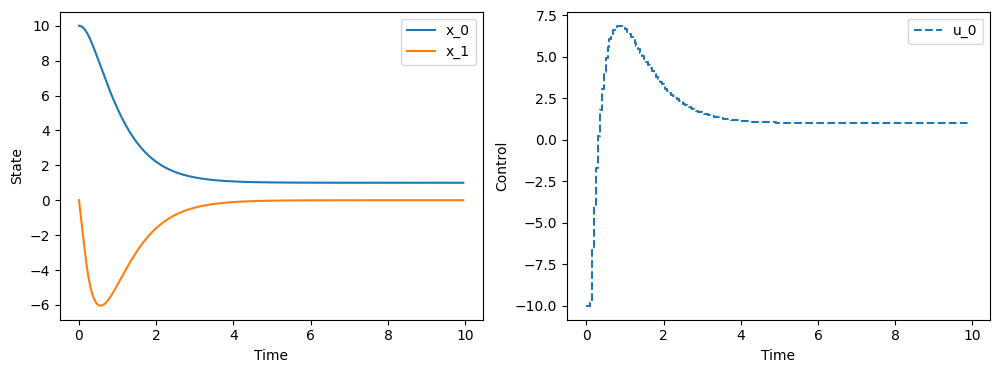

In [9]:
X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("State")

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Control")

plt.savefig("images/chap7_qp_ipopt.pdf")
plt.show()

[*] solver: ipopt, elapsed time: 0.002419s


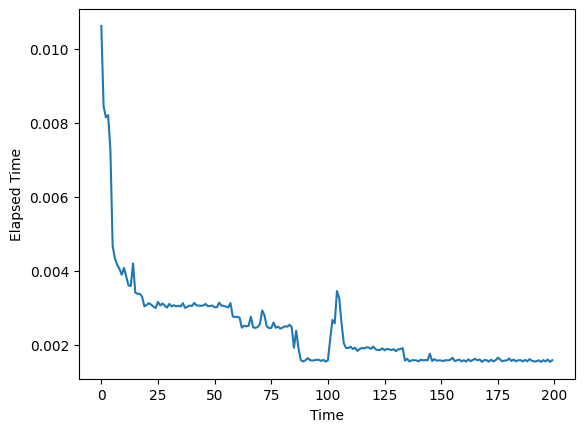

In [10]:
Times_ipopt = np.array(Times_ipopt)
print(f"[*] solver: ipopt, elapsed time: {Times_ipopt.mean():1f}s")
plt.plot(Times_ipopt)
plt.xlabel("Time")
plt.ylabel("Elapsed Time")

plt.savefig("images/chap7_qp_ipopt_time.png")
plt.show()

In [11]:
t_span = [0,10]
t_eval = np.arange(*t_span,dt)

x_init = casadi.DM([10,0]) # 初期値
x0 = casadi.DM.zeros(total)

I = make_integrator()

Times_osqp = []
X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    start_time = time.perf_counter()
    u_opt,x0 = compute_optimal_control(S_qp,x_current,x0)
    Times_osqp.append(time.perf_counter() - start_time)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 62, constraints m = 102
          nnz(P) + nnz(A) = 284
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, 
iter   objective    pri res    dua res    rho
   1  -7.4246e+00   9.97e+00   5.62e+03   1.00e-01
  25   5.4743e+02   2.56e-03   2.66e-02   1.00e-01

status:               solved
number of iterations: 25
optimal objective:    547.4299
optimal rho

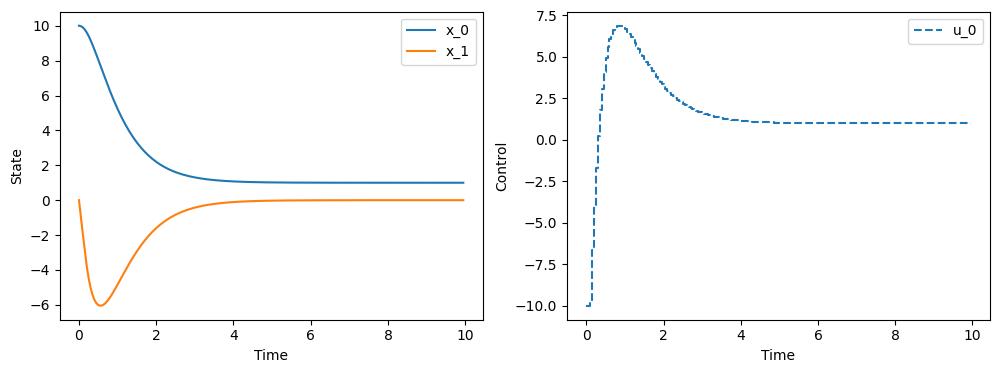

In [12]:
X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("State")

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Control")

plt.savefig("images/chap7_qp_osqp.png")
plt.show()

[*] solver: osqp, elapsed time: 0.000134s


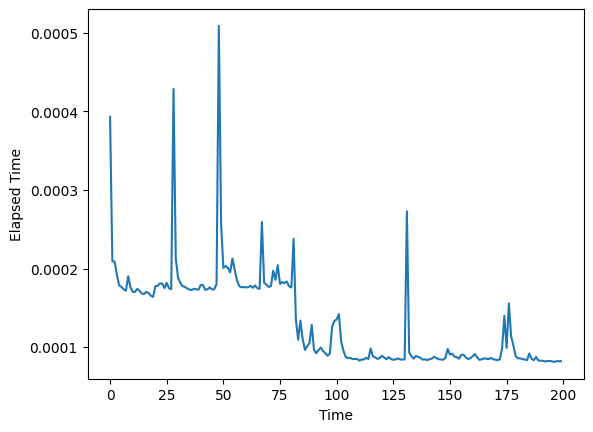

In [13]:
Times_osqp = np.array(Times_osqp)
print(f"[*] solver: osqp, elapsed time: {Times_osqp.mean():1f}s")
plt.plot(Times_osqp)
plt.xlabel("Time")
plt.ylabel("Elapsed Time")

plt.savefig("images/chap7_qp_osqp_time.png")
plt.show()

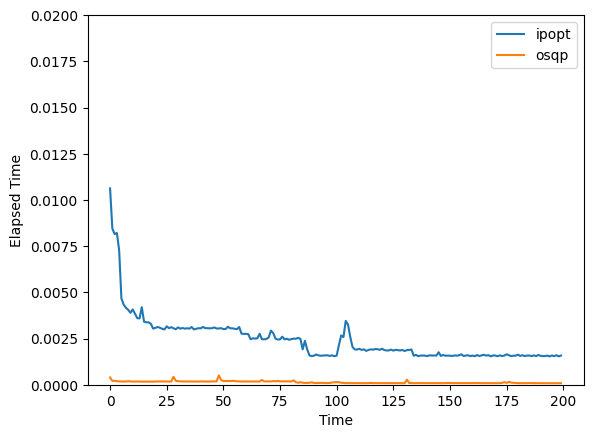

In [14]:
plt.plot(Times_ipopt,label="ipopt")
plt.plot(Times_osqp,label="osqp")
plt.ylim((0,0.02))
plt.legend()
plt.xlabel("Time")
plt.ylabel("Elapsed Time")

plt.savefig("images/chap7_qp_time_comparison.png")
plt.show()